Get statistics about the dataset

In [83]:
import sparqlqueries as sq
import pandas as pd
import matplotlib.pyplot as plt
import paths as p
import json
from tqdm import tqdm

In [84]:
melart_annotations=json.load(open(p.MELART_ANNOTATIONS_PATH, 'r'))

In [85]:
artworks_qids=dict() # split -> list of qids (keys from the melart annotations)
for qid,melart_artwork in melart_annotations.items():
    split=melart_artwork['split']
    if split not in artworks_qids:
        artworks_qids[split]=[]
    artworks_qids[split].append(qid)
print([f"Split {split}: {len(qids)} artworks" for split,qids in artworks_qids.items()])

['Split test: 100 artworks', 'Split train: 1188 artworks', 'Split val: 328 artworks']


In [86]:
all_qids=[qid for split,qids in artworks_qids.items() for qid in qids]
print(f"Total: {len(all_qids)} artworks")

Total: 1616 artworks


In [87]:
mentions_qids=set()
mention_counts=dict()
split_mention_counts=dict()
for split,qids in artworks_qids.items():
    split_mention_counts[split]=0
    for qid in qids:
        for match_list in melart_annotations[qid]['visual_el_matches']+melart_annotations[qid]['contextual_el_matches']:
            split_mention_counts[split]+=len(match_list)
            for match in match_list:
                mentions_qids.add(match['qid'])
                if match['qid'] not in mention_counts:
                    mention_counts[match['qid']]=0
                mention_counts[match['qid']]+=1
total_mentions=sum(mention_counts.values())
print(f"Total: {len(mentions_qids)} entities in the mentions")
print(f"Total: {total_mentions} mentions")
print("Mentions per split")
print(split_mention_counts)

Total: 1306 entities in the mentions
Total: 6585 mentions
Mentions per split
{'test': 645, 'train': 4632, 'val': 1308}


Read jsonl of candidates

In [88]:
candidates=dict()
with open(p.CANDIDATES_FILE_PATH, 'r') as f:
    for line in f:
        candidate=json.loads(line)
        qid=candidate['qid']
        candidates[qid]=candidate
print(f"Read {len(candidates)} candidates")

Read 52769 candidates


In [89]:
def get_all_types(qid_list):
    """Get all types in the wikidata hierarchy for a list of qids, return a dataframe with columns 'qid', 'type' and 'type_label'"""
    sparql_query="""
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX p: <http://www.wikidata.org/prop/>
    prefix ps: <http://www.wikidata.org/prop/statement/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT DISTINCT ?qid ?type WHERE{
        VALUES ?qid { %s }
        ?qid p:P31 ?statement0.
        ?statement0 (ps:P31/(wdt:P279*)) ?type.
        FILTER ( STRSTARTS(STR(?type), STR(wd:)))
    }
    """ % ' '.join([f'wd:{qid}' for qid in qid_list])
    results=sq.sparql_pandas_query(sparql_query)
    results['qid']=results['qid'].apply(lambda x: x.split('/')[-1])
    results['type']=results['type'].apply(lambda x: x.split('/')[-1])
    return results
get_all_types(['Q159099','Q259261'])

,qid,type
0,Q159099,Q103940464
1,Q159099,Q106559804
2,Q159099,Q110224119
3,Q159099,Q110551885
4,Q159099,Q12898224
5,Q159099,Q154954
6,Q159099,Q159344
7,Q159099,Q164509
8,Q159099,Q215627
9,Q159099,Q24229398


In [99]:
# dataframe with qid and type
dfs=[]
batch_size=1000
all_candidate_qids=list(candidates.keys())
batched_candidates=[{qid:candidates[qid] for qid in all_candidate_qids[i:i+batch_size]} for i in range(0, len(all_candidate_qids), batch_size)]
dataset_types=[candidates[qid]["types"].keys() for qid in all_candidate_qids]
mentioned_types=[candidates[qid]["types"].keys() for qid in all_candidate_qids if qid in mentions_qids]
dataset_types=list(set([item for sublist in dataset_types for item in sublist]))
mentioned_types=list(set([item for sublist in mentioned_types for item in sublist]))
for batch in tqdm(batched_candidates):
    types_entity_df=get_all_types(batch.keys())
    types_entity_df=types_entity_df[types_entity_df['type'].isin(mentioned_types)]
    dfs.append(types_entity_df)
df_types=pd.concat(dfs)
print("Total candidates type triples:", len(df_types))

100%|██████████| 53/53 [00:23<00:00,  2.29it/s]

Total candidates type triples: 98623


In [101]:
mentioned_types

['Q876459',
 'Q2270442',
 'Q44613',
 'Q161705',
 'Q16513881',
 'Q114392939',
 'Q1142281',
 'Q16970',
 'Q3235597',
 'Q24354',
 'Q2627975',
 'Q31629',
 'Q4193029',
 'Q134390',
 'Q2537829',
 'Q114401982',
 'Q5783996',
 'Q392371',
 'Q13539802',
 'Q7543083',
 'Q395295',
 'Q7725634',
 'Q39367',
 'Q96376684',
 'Q15275719',
 'Q39594',
 'Q38048707',
 'Q15243209',
 'Q3658341',
 'Q840482',
 'Q108178728',
 'Q1640361',
 'Q3305213',
 'Q15698333',
 'Q185187',
 'Q16514343',
 'Q87410915',
 'Q57659484',
 'Q1668124',
 'Q17374546',
 'Q12280',
 'Q16521098',
 'Q181414',
 'Q12160552',
 'Q67206785',
 'Q3867560',
 'Q6517872',
 'Q2368508',
 'Q7257',
 'Q5465729',
 'Q2995443',
 'Q2065736',
 'Q4115680',
 'Q1852859',
 'Q1549591',
 'Q43412',
 'Q58483083',
 'Q371174',
 'Q124936',
 'Q33837',
 'Q1250464',
 'Q51929311',
 'Q216353',
 'Q8928',
 'Q2666904',
 'Q13417114',
 'Q43702',
 'Q20643955',
 'Q678146',
 'Q21070568',
 'Q3537778',
 'Q124078422',
 'Q11197007',
 'Q113103481',
 'Q23002054',
 'Q97466613',
 'Q207452',
 'Q850

In [102]:
df_types[df_types['qid']=='Q345']

,qid,type
15760,Q345,Q13002315
15766,Q345,Q20643955
15767,Q345,Q21070568
15776,Q345,Q4271324
15779,Q345,Q5


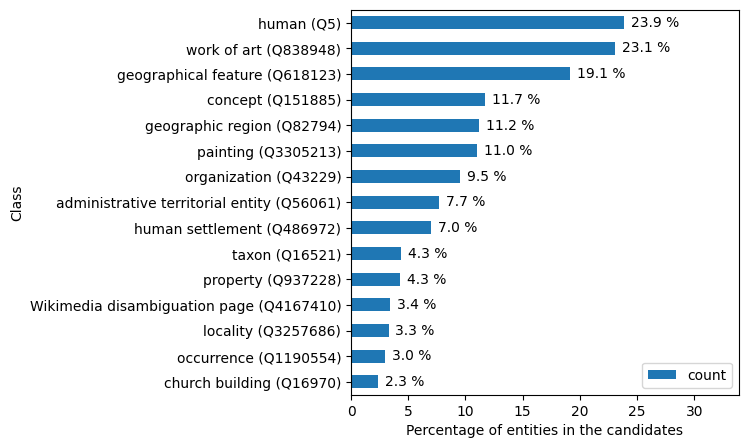

In [103]:
# count of types
type_counts=df_types['type'].value_counts()
#normalize
type_counts=type_counts*100/len(candidates)
k=15
plot_df=pd.DataFrame(type_counts.head(k))
plot_labels=sq.sparql_all_lables(plot_df.index.to_list())
plot_df["type_label"]=plot_df.index.map(lambda x: f"{plot_labels[x][0]} ({x})")
plot_df=plot_df.set_index("type_label")
ax=plot_df.plot(kind='barh', figsize=(5,5), ylabel='Class', xlabel='Percentage of entities in the candidates', xlim=(0,max(type_counts.head(10))+10))
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5)
plt.savefig("figures/types_candidates.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [104]:
df_types_mentions=df_types[df_types['qid'].isin(mentions_qids)]
print("Total mention types triples:", len(df_types_mentions))

Total mention types triples: 3650


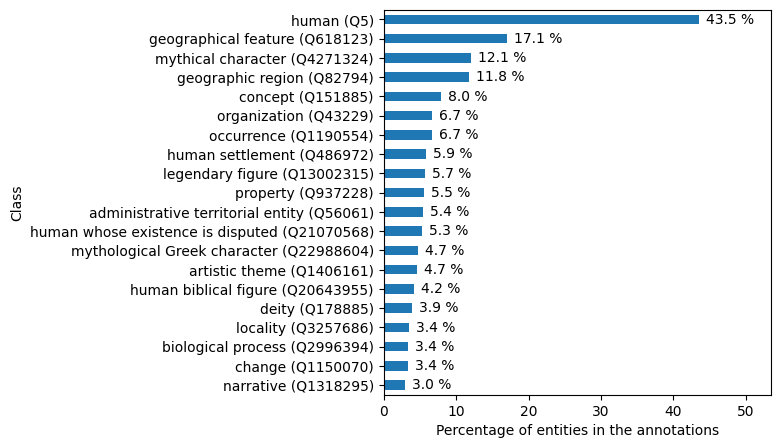

In [105]:
type_counts_mentions=df_types_mentions['type'].value_counts()
#normalize
type_counts_mentions=type_counts_mentions*100/len(mentions_qids)
k=20
plot_df=pd.DataFrame(type_counts_mentions.head(k))
plot_labels=sq.sparql_all_lables(plot_df.index.to_list())
plot_df["type_label"]=plot_df.index.map(lambda x: f"{plot_labels[x][0]} ({x})")
plot_df=plot_df.set_index("type_label")
ax=plot_df.plot(kind='barh', figsize=(5,5), ylabel='Class', xlabel='Percentage of entities in the annotations', xlim=(0,max(type_counts_mentions.head(k))+10), legend=False)
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5)
plt.savefig("figures/types_mentions.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [106]:
# legal persons (Q3778211) that are not humans (Q5)
legal_persons_df=df_types_mentions[df_types_mentions['type']=='Q3778211']
humans_df=df_types_mentions[df_types_mentions['type']=='Q5']
weird_legal_persons_df=legal_persons_df[~legal_persons_df['qid'].isin(humans_df['qid'])]
# distinct qids
weird_legal_persons_qids=set(weird_legal_persons_df['qid'])
weird_legal_persons_qids

set()

[Text(5, 0, '43.5 %'),
 Text(5, 0, '17.1 %'),
 Text(5, 0, '12.1 %'),
 Text(5, 0, '11.8 %'),
 Text(5, 0, '8.0 %'),
 Text(5, 0, '6.7 %'),
 Text(5, 0, '6.7 %'),
 Text(5, 0, '5.9 %'),
 Text(5, 0, '5.7 %'),
 Text(5, 0, '5.5 %'),
 Text(5, 0, '5.4 %'),
 Text(5, 0, '5.3 %'),
 Text(5, 0, '4.7 %'),
 Text(5, 0, '4.7 %'),
 Text(5, 0, '4.2 %')]

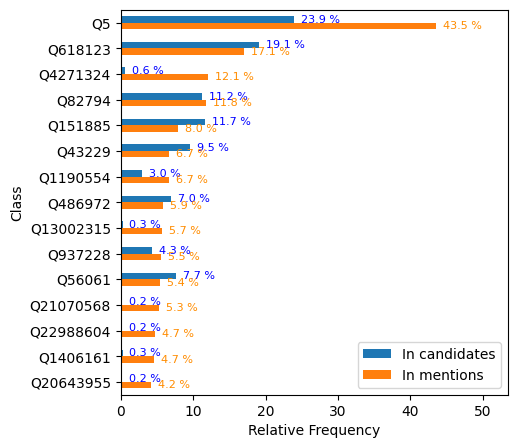

In [107]:
# combine the two type_count series into a dataframe
df_type_counts=pd.concat([type_counts, type_counts_mentions], axis=1)
df_type_counts.fillna(0, inplace=True)
df_type_counts.columns=['In candidates','In mentions']
df_type_counts.sort_values(by='In mentions', ascending=False, inplace=True)
ax=df_type_counts.head(15).plot(kind='barh', figsize=(5,5), ylabel='Class', xlabel='Relative Frequency', xlim=(0,max(df_type_counts.head(15).max())+10), legend=True)
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5, color='blue', fontsize=8)
ax.bar_label(ax.containers[1], fmt='%.1f %%', padding=5, color='darkorange', fontsize=8)

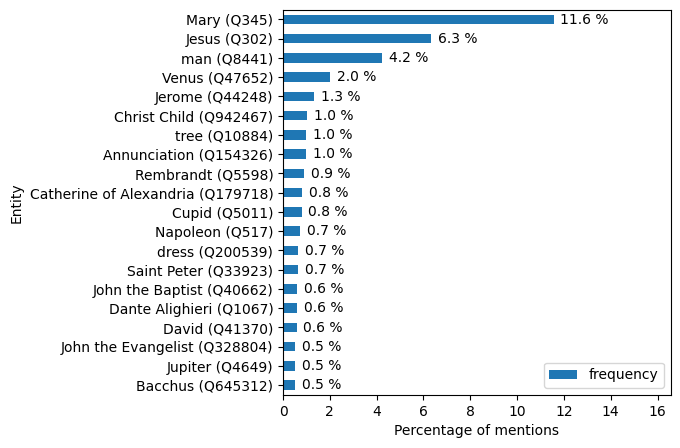

In [108]:
df_mention_counts=pd.DataFrame(mention_counts.items(), columns=['qid','count'])
mentions_labels=sq.sparql_all_lables(list(mentions_qids))
df_mention_counts['label']=df_mention_counts['qid'].map(lambda x: f"{mentions_labels[x][0]} ({x})")
df_mention_counts["frequency"]=df_mention_counts['count']*100/total_mentions
df_mention_counts.sort_values(by='count', ascending=False, inplace=True)
k=20
ax=df_mention_counts.head(k).plot(kind='barh', x='label', y='frequency', figsize=(5,5), xlabel='Percentage of mentions', ylabel='Entity', xlim=(0,max(df_mention_counts.head(k)['frequency'])+5))
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5)
plt.savefig("figures/top_entities_mentions.pdf", format="pdf", bbox_inches='tight')

In [109]:
df_mention_counts["cum_frequency"]=df_mention_counts['frequency'].cumsum()
df_mention_counts["rank"]=range(1,len(df_mention_counts)+1)
df_mention_counts["rank_relative"]=df_mention_counts["rank"]*100/len(df_mention_counts)
df_mention_counts.head(10)

,qid,count,label,frequency,cum_frequency,rank,rank_relative
0,Q345,761,Mary (Q345),11.556568,11.556568,1,0.076570
2,Q302,416,Jesus (Q302),6.317388,17.873956,2,0.153139
140,Q8441,279,man (Q8441),4.236902,22.110858,3,0.229709
31,Q47652,132,Venus (Q47652),2.004556,24.115414,4,0.306279
22,Q44248,86,Jerome (Q44248),1.305998,25.421412,5,0.382848
1,Q942467,68,Christ Child (Q942467),1.032650,26.454062,6,0.459418
188,Q10884,66,tree (Q10884),1.002278,27.456340,7,0.535988
15,Q154326,65,Annunciation (Q154326),0.987092,28.443432,8,0.612557
409,Q5598,58,Rembrandt (Q5598),0.880790,29.324222,9,0.689127
46,Q179718,54,Catherine of Alexandria (Q179718),0.820046,30.144267,10,0.765697


5% of entities account for 50% of mentions
33% of entities account for 80% of mentions
55% of entities account for 90% of mentions


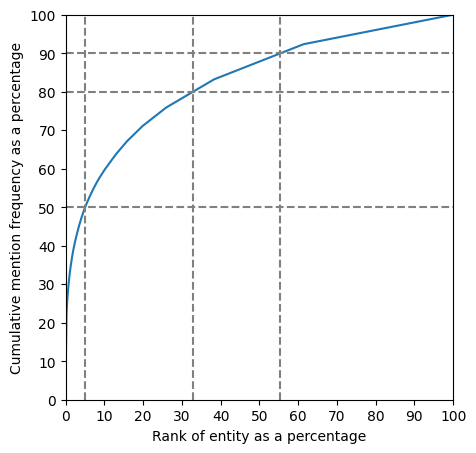

In [110]:
ax=df_mention_counts.plot(x='rank_relative', y='cum_frequency', figsize=(5,5), xlabel='Rank of entity as a percentage', ylabel='Cumulative mention frequency as a percentage', xticks=range(0,101,10), yticks=range(0,101,10), xlim=(0,100), ylim=(0,100), legend=False)
crossings=[50,80,90]
for crossing in crossings:
    y=crossing
    x=df_mention_counts[df_mention_counts["cum_frequency"]>=y].iloc[0]["rank_relative"]
    ax.axhline(y, color='grey', linestyle='--')
    ax.axvline(x, color='grey', linestyle='--')
    print(f"{round(x)}% of entities account for {y}% of mentions")
    #ax.text(x+1, y+1, text, color='red')
plt.savefig("figures/cumulative_mentions.pdf", format="pdf", bbox_inches='tight')


Adjust the types according to the mentions count. For instance Mary is mentioned multiple types, so her types are "mentioned" multiple times.

In [111]:
#combine df_mention_counts and df_types
df_mention_types=df_mention_counts.merge(df_types, on='qid')
df_mention_types.head()

,qid,count,label,frequency,cum_frequency,rank,rank_relative,type
0,Q345,761,Mary (Q345),11.556568,11.556568,1,0.07657,Q13002315
1,Q345,761,Mary (Q345),11.556568,11.556568,1,0.07657,Q20643955
2,Q345,761,Mary (Q345),11.556568,11.556568,1,0.07657,Q21070568
3,Q345,761,Mary (Q345),11.556568,11.556568,1,0.07657,Q4271324
4,Q345,761,Mary (Q345),11.556568,11.556568,1,0.07657,Q5


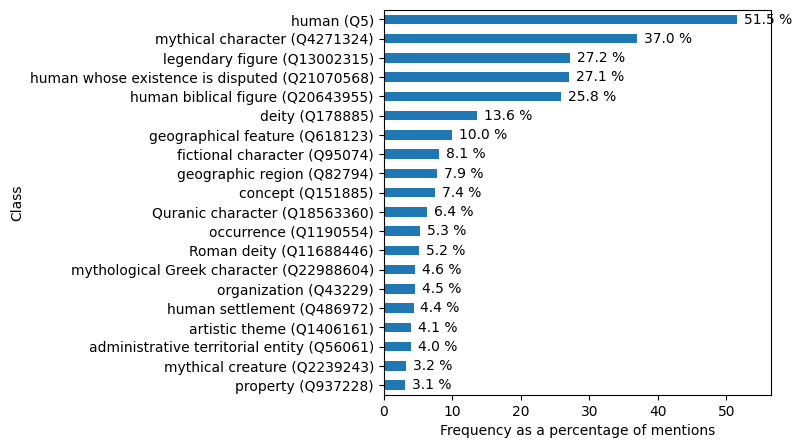

In [112]:
# group by type and sum the counts
df_mention_types_grouped=df_mention_types.groupby('type').sum(numeric_only=True).sort_values(by='count', ascending=False)
# keep only the count column
df_mention_types_grouped=df_mention_types_grouped[['count']]
# normalize
df_mention_types_grouped['count_norm']=df_mention_types_grouped['count']*100/total_mentions
k=20
ax=df_mention_types_grouped.head(k).plot.barh(y='count_norm', figsize=(5,5), xlabel='Frequency as a percentage of mentions', ylabel='Class', xlim=(0,max(df_mention_types_grouped['count_norm'].head(k))+5), legend=False)
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5)
# add labels
type_labels=sq.sparql_all_lables(df_mention_types_grouped.head(k).index.to_list())
ax.set_yticklabels([f"{type_labels[type][0]} ({type})" for type in df_mention_types_grouped.head(k).index])

plt.savefig("figures/top_types_mentions.pdf", format="pdf", bbox_inches='tight')

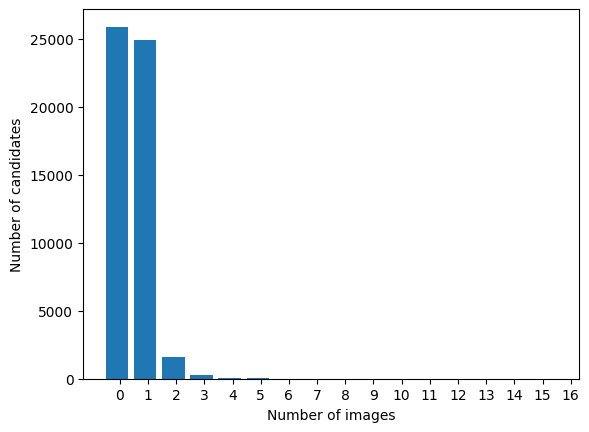

In [113]:
img_per_candidate=[len(candidates[qid]['images']) for qid in all_candidate_qids]
plt.hist(img_per_candidate, bins=range(0, max(img_per_candidate)+1), width=0.8, align='left')
plt.xticks(range(0, max(img_per_candidate)+1))
plt.xlabel('Number of images')
plt.ylabel('Number of candidates')
plt.savefig("figures/images_per_candidate.pdf", format="pdf", bbox_inches='tight')

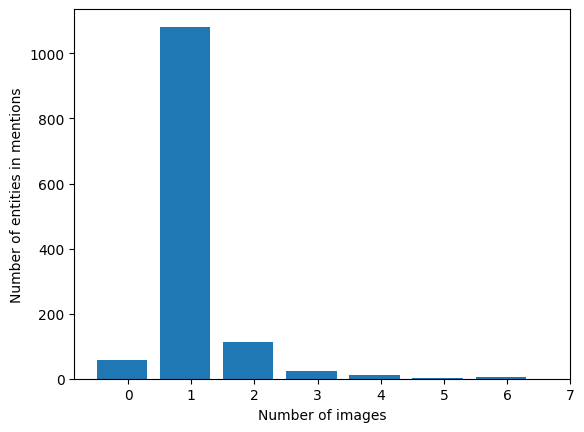

In [114]:
img_per_mention=[len(candidates[qid]['images']) for qid in candidates.keys() if qid in mentions_qids]
plt.hist(img_per_mention, bins=range(0, max(img_per_mention)+1), width=0.8 ,  align='left')
plt.xticks(range(0, max(img_per_mention)+1))
plt.xlabel('Number of images')
plt.ylabel('Number of entities in mentions')
plt.savefig("figures/images_per_mention.pdf", format="pdf", bbox_inches='tight')
#add labels with the numbers of the bars


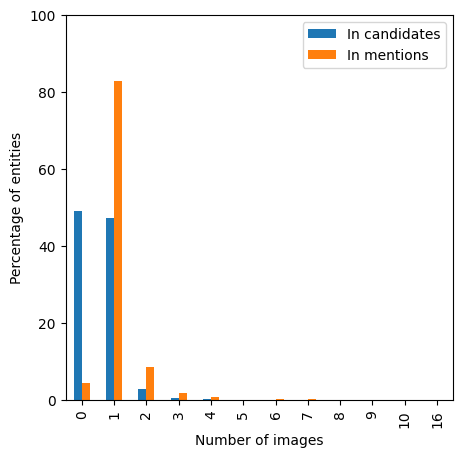

In [146]:
# img_per_candidate and img_per_mention in the same plot
# counts for each bin with value_counts
img_per_candidate_counts=pd.Series(img_per_candidate).value_counts().sort_index()
img_per_mention_counts=pd.Series(img_per_mention).value_counts().sort_index()
# normalize
img_per_candidate_counts_norm=img_per_candidate_counts*100/len(candidates)
img_per_mention_counts_norm=img_per_mention_counts*100/len(mentions_qids)
# combine
img_per_df=pd.concat([img_per_candidate_counts_norm, img_per_mention_counts_norm], axis=1)
img_per_df.columns=['In candidates','In mentions']
img_per_df.fillna(0, inplace=True)
img_per_df.plot(kind='bar', figsize=(5,5), ylabel='Percentage of entities', xlabel='Number of images', ylim=(0,100))
plt.savefig("figures/images_per_entity.pdf", format="pdf", bbox_inches='tight')

In [145]:
img_per_df

,In candidates,In mentions
0,49.061002,4.441041
1,47.272073,82.848392
2,2.958176,8.652374
3,0.471868,1.837672
4,0.132654,0.765697
5,0.054957,0.076570
6,0.026531,0.153139
7,0.011370,0.153139
8,0.003790,0.000000
9,0.003790,0.000000


In [132]:
sentence_stats=[]
for qid in all_qids:
    split=melart_annotations[qid]['split']
    annotations=melart_annotations[qid]
    fields={'visual_el_matches':'visual_sentences','contextual_el_matches':'contextual_sentences'}
    visual_matches=annotations['visual_el_matches']
    contextual_matches=annotations['contextual_el_matches']
    for match_field, sentence_field in fields.items():
        type_sentence=match_field.split('_')[0]
        matches=annotations[match_field]
        for i,match in enumerate(matches):
            if len(match)==0:
                continue
            sentence=annotations[sentence_field][i]
            stats={'qid':qid, 'type':type_sentence, 'n_mentions':len(match), 'n_words':len(sentence.split()), 'split':split}
            sentence_stats.append(stats)
df_sentence_stats=pd.DataFrame(sentence_stats)
df_sentence_stats.head()


,qid,type,n_mentions,n_words,split
0,Q1608116,visual,1,30,test
1,Q1608116,contextual,2,28,test
2,Q3797775,visual,1,38,test
3,Q3797775,visual,3,44,test
4,Q3797775,contextual,2,29,test


Text(0, 0.5, 'Number of sentences')

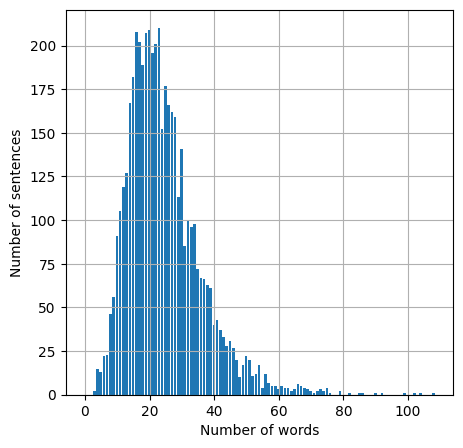

In [133]:
df_sentence_stats['n_words'].hist(bins=range(0, max(df_sentence_stats['n_words'])+1), width=0.8, align='left', figsize=(5,5))
plt.xlabel('Number of words')
plt.ylabel('Number of sentences')

Text(0, 0.5, 'Number of sentences')

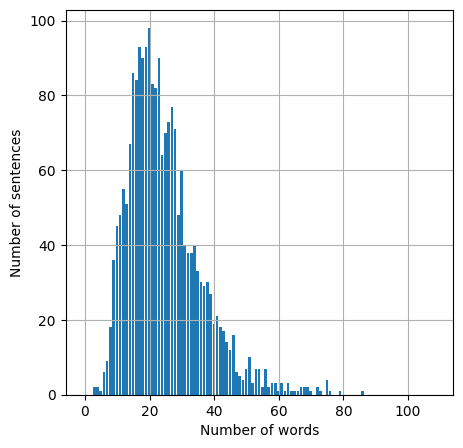

In [134]:
df_sentence_stats[df_sentence_stats['type']=='visual']['n_words'].hist(bins=range(0, max(df_sentence_stats['n_words'])+1), width=0.8, align='left', figsize=(5,5))
plt.xlabel('Number of words')
plt.ylabel('Number of sentences')

Text(0, 0.5, 'Number of sentences')

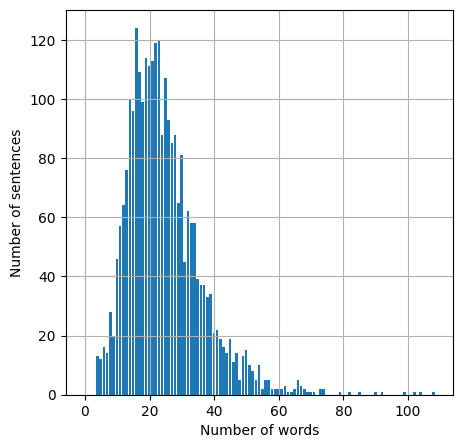

In [135]:
df_sentence_stats[df_sentence_stats['type']=='contextual']['n_words'].hist(bins=range(0, max(df_sentence_stats['n_words'])+1), width=0.8, align='left', figsize=(5,5))
plt.xlabel('Number of words')
plt.ylabel('Number of sentences')

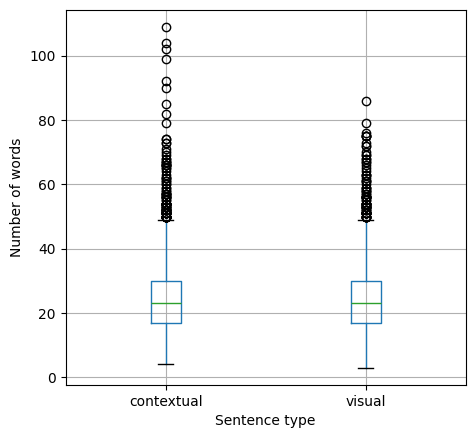

In [136]:
#boxplot with the sentence length by type
ax=df_sentence_stats.boxplot(column='n_words', by='type', figsize=(5,5))
plt.title('')
plt.suptitle('')
ax.set_title('')
ax.get_figure().suptitle("")
ax.set_xlabel('Sentence type')
ax.set_ylabel('Number of words')
plt.savefig("figures/sentence_length_by_type.pdf", format="pdf", bbox_inches='tight')

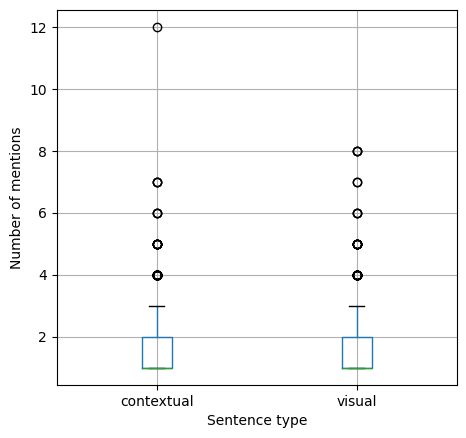

In [137]:
ax=df_sentence_stats.boxplot(column='n_mentions', by='type', figsize=(5,5))
plt.title('')
plt.suptitle('')
ax.set_title('')
ax.get_figure().suptitle("")
ax.set_xlabel('Sentence type')
ax.set_ylabel('Number of mentions')
plt.savefig("figures/mentions_by_sentence_type.pdf", format="pdf", bbox_inches='tight')

In [138]:
#compute mean mentions per word
df_sentence_stats['mentions_per_word']=df_sentence_stats['n_mentions']/df_sentence_stats['n_words']
df_sentence_stats.groupby('type')['mentions_per_word'].mean()

type
contextual    0.064623
visual        0.065056
Name: mentions_per_word, dtype: float64

In [139]:
# total mentions per sentence type
df_sentence_stats.groupby('type').sum(numeric_only=True)

,n_mentions,n_words,mentions_per_word
type,,,
contextual,3669,67167,175.515845
visual,2916,52393,137.789029


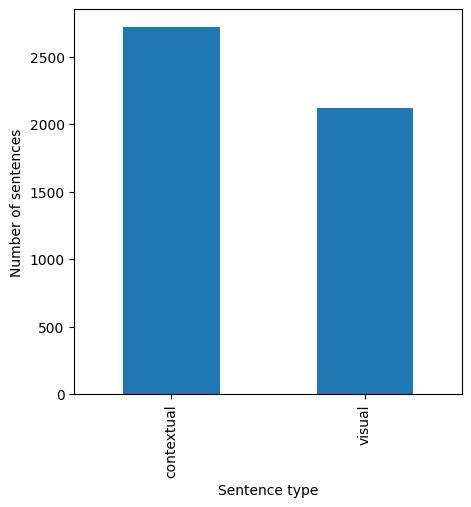

In [140]:
#number of sentnces by type
sentence_counts=df_sentence_stats.groupby('type').size()
sentence_counts.plot(kind='bar', figsize=(5,5))
plt.xlabel('Sentence type')
plt.ylabel('Number of sentences')
plt.savefig("figures/sentence_counts_by_type.pdf", format="pdf", bbox_inches='tight')

In [141]:
sentence_counts

type
contextual    2716
visual        2118
dtype: int64

In [142]:
sentence_counts["visual"]/(sentence_counts["contextual"]+sentence_counts["visual"])

0.4381464625568887

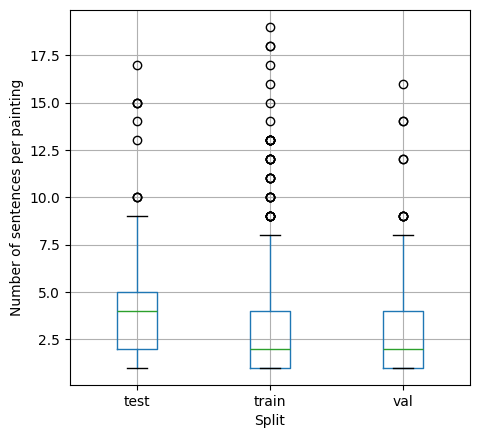

In [143]:
#boxplot with number of sentences per painting by split
#group by qid and split, count the rows
df_sentence_counts=df_sentence_stats.groupby(['qid','split']).size().reset_index(name='n_sentences')
ax=df_sentence_counts.boxplot(column='n_sentences', by='split', figsize=(5,5))
plt.title('')
plt.suptitle('')
ax.set_title('')
ax.get_figure().suptitle("")
ax.set_xlabel('Split')
ax.set_ylabel('Number of sentences per painting')
plt.savefig("figures/sentence_counts_by_split.pdf", format="pdf", bbox_inches='tight')

In [144]:
df_sentence_counts.groupby('split').describe()

n_sentences                                              
            count      mean       std  min  25%  50%  75%   max
split                                                          
test        100.0  4.430000  3.370265  1.0  2.0  4.0  5.0  17.0
train      1188.0  2.896465  2.441612  1.0  1.0  2.0  4.0  19.0
val         328.0  2.896341  2.232972  1.0  1.0  2.0  4.0  16.0